# Cleaner data experiments

Building on the conclusions from `04-more-experiments.ipynb` to run experiments on cleaner data.

In [1]:
import functools
import gc

from fastai.vision.all import *
import mlflow

import experiments

%config InlineBackend.figure_format = 'retina'

In [2]:
mlflow.set_tracking_uri("sqlite:////home/yanir/projects/deep-fish/mlruns.db")
mlflow.set_registry_uri("file:///home/yanir/projects/deep-fish/mlruns")
mlflow.set_experiment("rls-species-100-min-images-4-cleaner")

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
DATASET_PATH = Path("/home/yanir/projects/deep-fish/data/rls-species-100-min-images-4")
create_reproducible_learner = functools.partial(
    experiments.create_reproducible_learner,
    dataset_path=DATASET_PATH,
)

In [6]:
EXCLUDED_FILES = {
    "bathytoshia-lata-2.jpg": "duplicate of bathytoshia-lata-1.jpg",
    "bathytoshia-lata-4.jpg": "duplicate of bathytoshia-lata-3.jpg",
    "batrachomoeus-dubius-0.jpg": "multiple species",
    "batrachomoeus-dubius-4.jpg": "tiny fry",
    "heterodontus-portusjacksoni-egg-0.jpg": "egg",
}


def get_dataset_files(dataset_path):
    return get_image_files(dataset_path).filter(lambda path: path.name not in EXCLUDED_FILES)


def get_dataset_classes(dataset_path):
    return [experiments.get_species_from_path(path) for path in get_dataset_files(dataset_path)]


def create_db_kwargs(**extra_kwargs):
    return dict(
        get_items=get_dataset_files,
        splitter=TrainTestSplitter(test_size=0.2, stratify=get_dataset_classes(DATASET_PATH), random_state=19),
        **extra_kwargs,
    )

Found 534 items
2 datasets of sizes 427,107
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_species_from_path -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


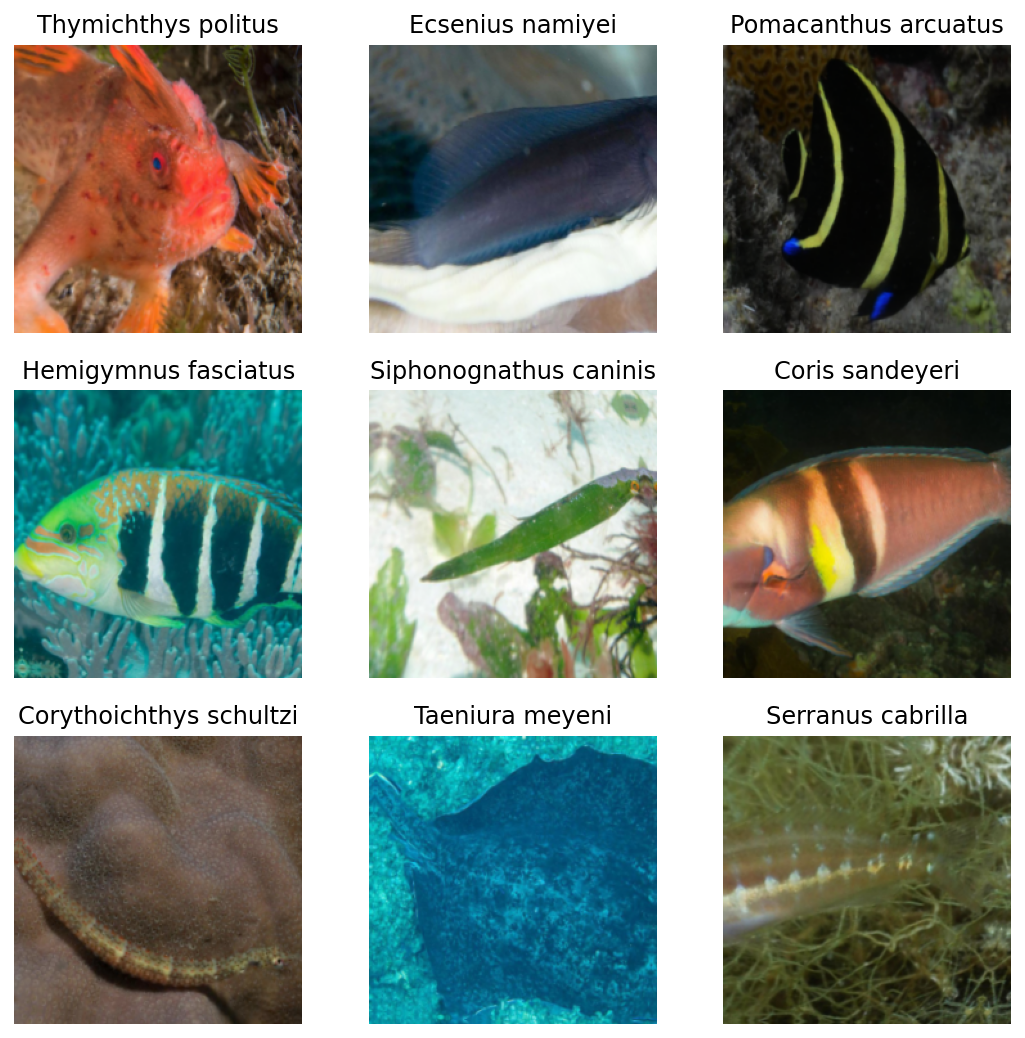

In [8]:
create_reproducible_learner(resnet18, db_kwargs=create_db_kwargs(), dls_kwargs=dict(verbose=True)).dls.show_batch()

In [7]:
with mlflow.start_run(run_name="initial"):
    learner = create_reproducible_learner(resnet18, db_kwargs=create_db_kwargs())

    mlflow.log_param("model", learner.arch.__name__)
    mlflow.log_param("item_tfms", "RandomResizedCrop(224, min_scale=0.5)")
    mlflow.log_param("batch_tfms", "aug_transforms()")

    learner.fine_tune(20)

    metrics = experiments.get_learner_metrics_with_tta(learner, tta_prefix="tta_", beta=0)
    mlflow.log_metrics(metrics)
metrics

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_10_accuracy,time
0,6.391387,5.734604,0.000000,0.065421,0.149533,00:06


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_10_accuracy,time
0,5.570807,4.933976,0.028037,0.074766,0.196262,00:06
1,5.387725,4.513279,0.093458,0.112150,0.252336,00:07
2,5.164326,4.129242,0.149533,0.205607,0.383178,00:07
3,4.855610,3.703436,0.186916,0.336449,0.495327,00:07
4,4.426812,3.237065,0.280374,0.429907,0.607477,00:07
5,4.054610,2.895930,0.336449,0.467290,0.691589,00:07
6,3.651518,2.654376,0.401869,0.514019,0.738318,00:07
7,3.252355,2.448855,0.392523,0.560748,0.775701,00:07
8,2.880310,2.292503,0.429907,0.654206,0.831776,00:06
9,2.563338,2.175271,0.504673,0.663551,0.841121,00:07


{'train_loss': 0.9641474485397339,
 'valid_loss': 1.9348201751708984,
 'accuracy': 0.5327102541923523,
 'top_3_accuracy': 0.6915887594223022,
 'top_10_accuracy': 0.8598130941390991,
 'tta_accuracy': 0.5700934529304504,
 'tta_top_3_accuracy': 0.8130841255187988,
 'tta_top_10_accuracy': 0.9158878326416016}

In [9]:
with mlflow.start_run(run_name="crop-448-baseline"):
    learner = create_reproducible_learner(
        resnet18,
        db_kwargs=create_db_kwargs(
            item_tfms=RandomResizedCrop(448, min_scale=0.5), batch_tfms=aug_transforms(mult=2.0)
        ),
        dls_kwargs=dict(bs=16),
    )

    mlflow.log_param("model", learner.arch.__name__)
    mlflow.log_param("item_tfms", "RandomResizedCrop(448, min_scale=0.5)")
    mlflow.log_param("batch_tfms", "aug_transforms(mult=2.0)")
    mlflow.log_param("bs", 16)

    learner.fine_tune(200, freeze_epochs=10)

    metrics = experiments.get_learner_metrics_with_tta(learner, tta_prefix="tta_", beta=0)
    mlflow.log_metrics(metrics)
metrics

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_10_accuracy,time
0,6.457232,5.124568,0.000000,0.037383,0.084112,00:17
1,6.296614,4.926482,0.009346,0.056075,0.158879,00:17
2,5.942318,4.437579,0.074766,0.130841,0.299065,00:17
3,5.480309,3.864481,0.149533,0.252336,0.476636,00:17
4,4.822255,3.310798,0.214953,0.401869,0.635514,00:17
5,4.249732,2.952232,0.299065,0.514019,0.719626,00:15
6,3.595020,2.640356,0.411215,0.616822,0.766355,00:16
7,3.049495,2.472849,0.383178,0.616822,0.794393,00:17
8,2.572229,2.354207,0.429907,0.607477,0.822430,00:17
9,2.185367,2.182244,0.485981,0.691589,0.850467,00:17


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_10_accuracy,time
0,1.261259,2.064224,0.504673,0.710280,0.859813,00:21
1,1.216850,2.007657,0.514019,0.691589,0.841121,00:21
2,1.204561,1.961769,0.551402,0.738318,0.850467,00:21
3,1.034284,1.881643,0.523364,0.757009,0.869159,00:21
4,0.981970,1.785652,0.532710,0.775701,0.878505,00:21
5,0.915278,1.760175,0.570093,0.794393,0.887850,00:21
6,0.833275,1.695469,0.588785,0.822430,0.887850,00:21
7,0.800000,1.626153,0.570093,0.831776,0.925234,00:21
8,0.735336,1.593382,0.570093,0.813084,0.915888,00:21
9,0.670109,1.578232,0.570093,0.822430,0.915888,00:21


{'train_loss': 0.010637691244482994,
 'valid_loss': 1.2527402639389038,
 'accuracy': 0.7570093274116516,
 'top_3_accuracy': 0.8504672646522522,
 'top_10_accuracy': 0.9065420627593994,
 'tta_accuracy': 0.7383177280426025,
 'tta_top_3_accuracy': 0.8878504633903503,
 'tta_top_10_accuracy': 0.9439252614974976}